In [1]:
# Copyright (C) 2017 Zhixian MA <zxma_sjtu@qq.com>

# Do FIRST AGN feature learning by our code agn-ae

In [2]:
import numpy as np
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image as IPImage
from PIL import Image

import sys   
sys.setrecursionlimit(1000000)

In [3]:
from ConvAE import ConvAE
import utils

Using gpu device 0: GeForce 940MX (CNMeM is disabled, cuDNN 5105)


In [4]:
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne import PrintLayerInfo

In [5]:
# load data
import pickle
'''
fname = 'mnist/mnist.pkl'
fp = open(fname, 'rb')
train,valid,test = pickle.load(fp,encoding='latin1')
fp.close()
'''
folder = '../data'
ftype = 'fits'
savepath = 'sample_raw.pkl'
crop_box = (100,100)
res_box = (50,50)
X = utils.gen_sample(folder=folder, ftype=ftype,
                    savepath=savepath, crop_box=crop_box,
                    res_box=res_box)


In [6]:
X = X.astype('float32')
np.isnan(X).sum()
X[np.isnan(X)] = 0
# X_max = X.max(), print(X_max)
# X_min = X.min(), print(X_min)
# X_norm = (X - X_min) / (X_max - X_min)

In [7]:
X_norm = (X - X.min()) / (X.max() - X.min())
X_norm.max()

1.0

In [8]:
'''
X_train, y_train = train
X_test, y_test = test
# randomly select 10000 samples

print('X_train type and shape:', X_train.dtype, X_train.shape)
print('X_train.min():', X_train.min())
print('X_train.max():', X_train.max())

print('X_test type and shape:', X_test.dtype, X_test.shape)
print('X_test.min():', X_test.min())
print('X_test.max():', X_test.max())
'''

"\nX_train, y_train = train\nX_test, y_test = test\n# randomly select 10000 samples\n\nprint('X_train type and shape:', X_train.dtype, X_train.shape)\nprint('X_train.min():', X_train.min())\nprint('X_train.max():', X_train.max())\n\nprint('X_test type and shape:', X_test.dtype, X_test.shape)\nprint('X_test.min():', X_test.min())\nprint('X_test.max():', X_test.max())\n"

In [9]:
# define the net
# idx = np.random.permutation(X.shape[0])
# X = X_train[idx[0:1000],:]
X_in = X_norm.reshape(-1,1,50,50)
X_out = X_norm
kernel_size = [3, 5, 3]
kernel_num = [16, 16, 16]
pool_flag = [True, True, True]
fc_nodes = [128]
encode_nodes = 16
net = ConvAE(X_in=X_in, X_out=X_out, kernel_size=kernel_size, pool_flag=pool_flag,
             kernel_num=kernel_num, fc_nodes=fc_nodes, encode_nodes = 16)

In [10]:
I = X_in[0,0,:,:].reshape(50,50)
# plt.imshow(I)
I.max()
I.min()

0.0014218582

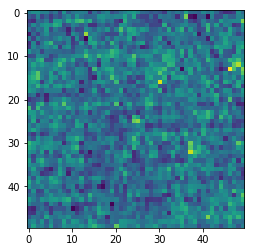

In [11]:
plt.imshow(I)

In [12]:
# generate layers
net.gen_layers()
net.layers

[(lasagne.layers.input.InputLayer, {'shape': (None, 1, 50, 50)}),
 (lasagne.layers.conv.Conv2DLayer,
  {'filter_size': 3, 'num_filters': 16, 'pad': 'valid'}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.conv.Conv2DLayer,
  {'filter_size': 5, 'num_filters': 16, 'pad': 'valid'}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.conv.Conv2DLayer,
  {'filter_size': 3, 'num_filters': 16, 'pad': 'valid'}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.shape.ReshapeLayer, {'shape': ([0], -1)}),
 (lasagne.layers.dense.DenseLayer, {'num_units': 128}),
 (lasagne.layers.dense.DenseLayer, {'name': 'encode', 'num_units': 16}),
 (lasagne.layers.dense.DenseLayer, {'num_units': 128}),
 (lasagne.layers.dense.DenseLayer, {'num_units': 256}),
 (lasagne.layers.shape.ReshapeLayer, {'shape': ([0], 16, 4, 4)}),
 (lasagne.layers.pool.Upscale2DLayer, {'scale_factor': 2}),
 (lasagne.layers.conv.Conv2DLayer,
  {'filter_size': 3, '

In [13]:
# Build the network and initilization
net.cae_build(learning_rate=0.0005, momentum=0.975, verbose=2)

In [14]:
# Train the network
net.cae_train()

Training the network...
# Neural Network with 87937 learnable parameters

## Layer information

name         size        total    cap.Y    cap.X    cov.Y    cov.X
-----------  --------  -------  -------  -------  -------  -------
input0       1x50x50      2500   100.00   100.00   100.00   100.00
conv2d1      16x48x48    36864   100.00   100.00     6.00     6.00
maxpool2d2   16x24x24     9216   100.00   100.00     6.00     6.00
conv2d3      16x20x20     6400    90.91    90.91    22.00    22.00
maxpool2d4   16x10x10     1600    90.91    90.91    22.00    22.00
conv2d5      16x8x8       1024    63.16    63.16    38.00    38.00
maxpool2d6   16x4x4        256    63.16    63.16    38.00    38.00
reshape7     256           256   100.00   100.00   100.00   100.00
dense8       128           128   100.00   100.00   100.00   100.00
encode       16             16   100.00   100.00   100.00   100.00
dense10      128           128   100.00   100.00   100.00   100.00
dense11      256           256   

In [15]:
# save result
net.cae_save('net.pkl')

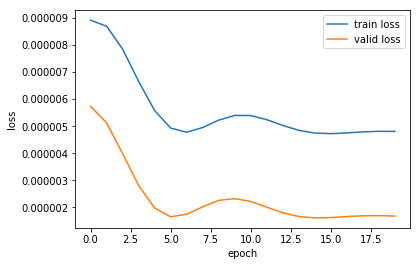

In [16]:
# Plot the loss curve
net.cae_eval()

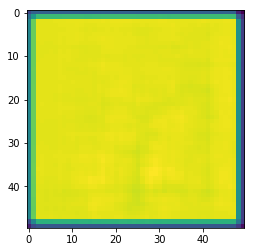

In [17]:
# from imp import reload
# reload(utils)
# Test the network
imgs = X_in.reshape(-1,50,50)
img_small = imgs[30,:,:]

# encode
img_en = utils.get_encode(net.cae, img_small)
# decode
img_de = utils.get_decode(net.cae, img_en)

# Compare
# img_pre = np.rint(img_de.reshape(50,50) * 256).astype(int)
# img_pre = np.clip(img_pre, a_min = 0, a_max = 255)
# img_pre = img_pre.astype('uint8')
img_pre = img_de.reshape(50,50)
plt.imshow(img_pre)

# img_pre = utils.get_predict(net.cae, img_small)

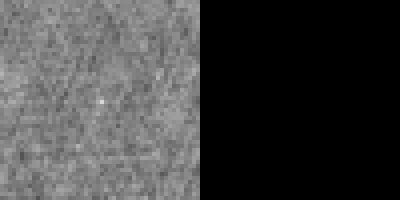

In [18]:
def get_picture_array(X, rescale=4):
    array = X.reshape(50,50)*255
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

def compare_images(img, img_pre):
    original_image = Image.fromarray(get_picture_array(255 * img))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(img_pre))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('test.png', format="PNG")
    return IPImage('test.png')

compare_images(img_small, img_pre)

<module 'matplotlib.pyplot' from '/home/mzx/work/deeplearning/convolutional_autoencoder/env/lib/python3.5/site-packages/matplotlib/pyplot.py'>

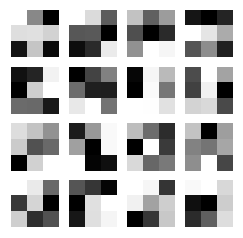

In [19]:
plot_conv_weights(net.cae.layers_[1], figsize=(4,4))

In [20]:
netInfo = PrintLayerInfo()
netInfo(net.cae)

# Neural Network with 87937 learnable parameters

## Layer information

name         size        total    cap.Y    cap.X    cov.Y    cov.X
-----------  --------  -------  -------  -------  -------  -------
input0       1x50x50      2500   100.00   100.00   100.00   100.00
conv2d1      16x48x48    36864   100.00   100.00     6.00     6.00
maxpool2d2   16x24x24     9216   100.00   100.00     6.00     6.00
conv2d3      16x20x20     6400    90.91    90.91    22.00    22.00
maxpool2d4   16x10x10     1600    90.91    90.91    22.00    22.00
conv2d5      16x8x8       1024    63.16    63.16    38.00    38.00
maxpool2d6   16x4x4        256    63.16    63.16    38.00    38.00
reshape7     256           256   100.00   100.00   100.00   100.00
dense8       128           128   100.00   100.00   100.00   100.00
encode       16             16   100.00   100.00   100.00   100.00
dense10      128           128   100.00   100.00   100.00   100.00
dense11      256           256   100.00   100.00   100.00

In [21]:
# from nolearn.lasagne.visualize import draw_to_notebook
# draw_to_notebook(net.cae)

Concating the maps
montage -mode concatenate -tile 4x C1/*.png C1/map_con.png


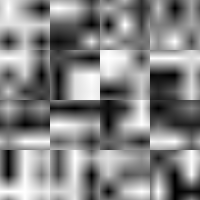

In [22]:
from imp import reload
reload(utils)
utils.get_concate(net.cae, layer_idx=1, savefolder='C1')
IPImage('C1/map_con.png')

Concating the maps
montage -mode concatenate -tile 4x C2/*.png C2/map_con.png


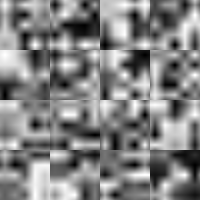

In [23]:
utils.get_concate(net.cae, layer_idx=3, savefolder='C2')
IPImage('C2/map_con.png')

Concating the convolved maps
montage -mode concatenate -tile 4x conv1/*.png conv1/conv_con.png


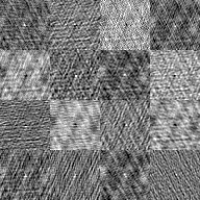

In [24]:
img_conv = utils.get_conv(net.cae, layer_idx=1, img=img_small, savefolder='conv1')
IPImage('conv1/conv_con.png')

Concating the convolved maps
montage -mode concatenate -tile 4x conv2/*.png conv2/conv_con.png


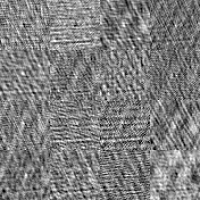

In [25]:
img_conv = utils.get_conv(net.cae, layer_idx=3, img=img_conv[0,:,:], savefolder='conv2')
IPImage('conv2/conv_con.png')

Concating the convolved maps
montage -mode concatenate -tile 4x conv3/*.png conv3/conv_con.png


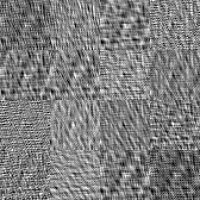

In [26]:
img_conv = utils.get_conv(net.cae, layer_idx=5, img=img_conv[0,:,:], savefolder='conv3')
IPImage('conv3/conv_con.png')